# Install additional dependencies

In [1]:
!pip install torchtyping

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtyping import TensorType

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Vision Transformer Model

In [5]:
class PatchAndPositionEmbedding(nn.Module):
    """
    Combines patch and position embeddings for Vision Transformer (ViT) models.

    Args:
        image_size (int, optional): Input image size (square). Default is 384.
        patch_size (int, optional): Patch size. Default is 16.
        embed_dim (int, optional): Embedding dimension. Default is 192.
        n_channels (int, optional): Number of input channels (e.g., 3 for RGB). Default is 3.

    Attributes:
        n_patches (int): Number of patches in the image.
        linear_projection (nn.Linear): Projects patches to embedding dimension.
        cls_token (nn.Parameter): Learnable class token.
        pos_embedding (nn.Parameter): Learnable position embeddings.
        unfold (nn.Unfold): Extracts image patches.
    """
    
    def __init__(self, image_size: int = 224, patch_size: int = 16, embed_dim: int = 192, n_channels: int = 3) -> None:
        """
        Initializes the PatchAndPositionEmbedding module.

        Args:
            image_size (int, optional): Size of the input image (assumed square). Default is 384.
            patch_size (int, optional): Size of each patch to be extracted from the image. Default is 16.
            embed_dim (int, optional): Dimensionality of the output embeddings. Default is 192.
            n_channels (int, optional): Number of input channels (e.g., 3 for RGB). Default is 3.
        """
        
        super(PatchAndPositionEmbedding, self).__init__()
        
        assert image_size % patch_size == 0, f"image_size of {image_size} is not divisible by patch_size of {patch_size}"
        
        self.n_patches = image_size * image_size // patch_size ** 2
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.n_channels = n_channels
        
        self.linear_projection = nn.Linear(self.patch_size ** 2 * self.n_channels, self.embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, self.embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(self.n_patches + 1, self.embed_dim))
        self.unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
        
        
    def forward(self, x: TensorType[torch.float32]) -> TensorType[torch.float32]:
        """
        Forward pass that computes patch embeddings, prepends the class token, and adds positional embeddings.

        Args:
            x (TensorType[torch.float32]): Input tensor of shape (C, H, W), where C is the number of channels, 
                              and H, W are the height and width of the image.

        Returns:
            TensorType[torch.float32]: Tensor of shape (batch_size, n_patches + 1, embed_dim), where `n_patches + 1` includes 
                          the class token, and `embed_dim` is the embedding dimension.
        """
        
        # patch embedding
        x = self.unfold(x).transpose(1, 2)
        x = self.linear_projection(x)
        
        # prepending class token
        batch_size = x.shape[0]
        
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # positional embedding
        pos_embeddings = self.pos_embedding.expand(batch_size, -1, -1)
        x = x + pos_embeddings

        return x

In [6]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.

    Args:
        image_size (int, optional): Input image size (square). Default is 224.
        patch_size (int, optional): Size of image patches. Default is 16.
        embed_dim (int, optional): Dimensionality of patch embeddings. Default is 192.
        n_layers (int, optional): Number of transformer encoder layers. Default is 12.
        n_heads (int, optional): Number of attention heads. Default is 4.
        mlp_size (int, optional): Size of the MLP layer. Default is 768.
        n_classes (int, optional): Number of output classes. Default is 10.
        n_channels (int, optional): Number of input channels (e.g., 3 for RGB). Default is 3.
        dropout (float, optional): Dropout rate. Default is 0.1.
        batch_first (bool, optional): If True, the batch dimension comes first. Default is False.

    Attributes:
        embedding (PatchAndPositionEmbedding): Patch and position embedding layer.
        transformer_encoder (nn.TransformerEncoder): Transformer encoder with multiple layers.
        MLP (nn.Sequential): Final classification layer with normalization and linear layers.
    """
    
    def __init__(
        self,
        image_size: int = 224,
        patch_size: int = 16,
        embed_dim: int = 192,
        n_layers: int = 12,
        n_heads: int = 4,
        mlp_size: int = 768,
        n_classes: int = 10,
        n_channels: int = 3,
        dropout: float = 0.1,
        batch_first: bool = False
    ) -> None:
        """
        Initializes the VisionTransformer model.

        Args:
            image_size (int, optional): Size of the input image. Default is 224.
            patch_size (int, optional): Size of image patches. Default is 16.
            embed_dim (int, optional): Dimensionality of patch embeddings. Default is 192.
            n_layers (int, optional): Number of transformer encoder layers. Default is 12.
            n_heads (int, optional): Number of attention heads. Default is 4.
            mlp_size (int, optional): Size of the MLP layer. Default is 768.
            n_classes (int, optional): Number of output classes. Default is 10.
            n_channels (int, optional): Number of input channels. Default is 3.
            dropout (float, optional): Dropout rate. Default is 0.1.
            batch_first (bool, optional): If True, batch dimension comes first. Default is False.
        """
        
        super(VisionTransformer, self).__init__()
        
        self.batch_first = batch_first
        
        self.embedding = PatchAndPositionEmbedding(image_size, patch_size, embed_dim, n_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=mlp_size,
            dropout=dropout,
            activation='gelu',
            batch_first=self.batch_first
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self.MLP = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, n_classes)
        )
        
        self._init_weights()
                
    def _init_weights(self):
        """
        Initializes the weights of the model, including the class token, positional embedding, 
        and the linear projection layer.
        """
        
        nn.init.trunc_normal_(self.embedding.cls_token, std=0.02)
        nn.init.trunc_normal_(self.embedding.pos_embedding, std=0.02)
        nn.init.xavier_normal_(self.embedding.linear_projection.weight)
        nn.init.zeros_(self.embedding.linear_projection.bias)
                    
    def forward(self, x: TensorType[torch.float32]) -> TensorType[torch.float32]:
        """
        Forward pass of the VisionTransformer model.

        Args:
            x (TensorType[torch.float32]): Input image tensor of shape (C, H, W), where C is the number of channels, 
                              and H, W are the height and width of the image.

        Returns:
            TensorType[torch.float32]: Output logits of shape (batch_size, n_classes), representing the class scores.
        """
        
        x = self.embedding(x)
        
        if not self.batch_first: 
            x = x.transpose(0, 1)
        
        x = self.transformer_encoder(x)
        
        cls_token = x[:, 0, :] if self.batch_first else x[0]
        
        logits = self.MLP(cls_token)
        
        return logits
        

# Preparing the data

In [7]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomVerticalFlip(p=0.5),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
train_dataset = ImageFolder(root='/kaggle/input/packed-fruits-and-vegetables-recognition-benchmark/train/train', transform=train_transforms)
test_dataset = ImageFolder(root='/kaggle/input/packed-fruits-and-vegetables-recognition-benchmark/test/test', transform=test_transforms)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=4)

In [10]:
X, y = next(iter(test_dataloader))

In [11]:
idx_to_class = train_dataset.find_classes(train_dataset.root)[0]
idx_to_class

['apple_fuji',
 'apple_golden',
 'apple_granny',
 'apple_ligol',
 'apple_red_delicious',
 'apple_spartan',
 'apricot_armenian',
 'apricot_jerdel',
 'avocado_hass',
 'avocado_zutano',
 'banana_mini',
 'banana_yellow',
 'beet_round',
 'cabbage_broccoli',
 'cabbage_cauliflower',
 'cabbage_peking',
 'cabbage_white',
 'carrot_carrot',
 'corn_corn',
 'cucumber_long',
 'cucumber_medium',
 'daikon_daikon',
 'garlic_garlic',
 'grape_black',
 'grape_green',
 'grape_pink',
 'grapefruit_grapefruit',
 'kiwi_kiwi',
 'lemon_orange',
 'lemon_yellow',
 'lime_lime',
 'mango_mango',
 'melon_torpeda',
 'nectarine_flat',
 'nectarine_round',
 'onion_purple',
 'onion_white',
 'orange_orange',
 'pear_conference',
 'pear_williams_rouge',
 'pepper_chili',
 'pepper_sweet_elonged',
 'pepper_sweet_green',
 'pepper_sweet_red',
 'pepper_sweet_yellow',
 'plum_pink',
 'plum_purple',
 'pomegranate_pomegranate',
 'pomelo_pomelo',
 'potato_pink',
 'potato_yellow',
 'pumpkin_elonged',
 'raddish_elonged',
 'raddish_round',

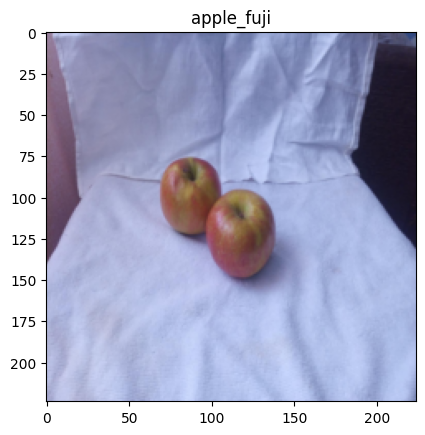

In [12]:
plt.title(idx_to_class[y[0].item()])
plt.imshow(X[0].permute(1, 2, 0))
plt.show()

In [13]:
X.shape, y.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

# Training the ViT

In [14]:
def train_epoch(dataloader: DataLoader, loss_fn: nn.modules.loss._Loss, optimizer: optim.Optimizer):    
    """
    Trains a model for one epoch using the provided dataloader, optimizer, and loss function.

    This function iterates over the training data in batches, computes the loss, performs backpropagation,
    and updates the model's weights using the optimizer. It also tracks and prints the current and average loss
    after every 10 batches.

    Args:
        dataloader (DataLoader): The DataLoader providing the training data in batches.
        optimizer (optim.Optimizer): The optimizer used to update the model's weights.
        loss_fn (nn.modules.loss._Loss): The loss function used to compute the difference between predictions and targets.

    Returns:
        None
    """
    avg_loss = 0.0

    ViT.train()
    for batch_index, (X, y) in enumerate(train_dataloader, 1):
        X, y = X.to(device), y.to(device)

        prediction = ViT(X)
        loss = loss_fn(prediction, y)

        avg_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            loss = loss.item()
            current_sample = batch_index * len(X)

            print(f'Current loss: {loss:.5f}, Average loss: {avg_loss / 10:.5f} [{current_sample} / {len(dataloader.dataset)}]')
            avg_loss = 0.0
        

In [27]:
def test_epoch(dataloader: DataLoader, loss_fn: nn.modules.loss._Loss, softmax: nn.Module) -> None:
    """
    Evaluates the model's performance on the test dataset for one epoch.

    This function iterates over the test data, computes the loss for each batch, and
    calculates the average loss across all batches. The model is set to evaluation mode
    to disable dropout and other training-specific behaviors.

    Args:
        dataloader (DataLoader): The DataLoader providing the test data in batches.
        loss_fn (nn.modules.loss._Loss): The loss function used to compute the difference between predictions and targets.

    Returns:
        None
    """
    ViT.eval()

    avg_test_loss = 0.0
    n_correct = 0

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            prediction = ViT(X)

            loss = loss_fn(prediction, y)
            avg_test_loss += loss.item()
            
            prediction = softmax(prediction)
            n_correct += (torch.argmax(prediction, dim=1) == y).sum()

    print(f'Average test loss: {avg_test_loss / len(dataloader):.5f}, Accuracy: {n_correct / len(dataloader.dataset) * 100:.2f}%')

In [16]:
ViT = VisionTransformer(batch_first=True, n_classes=len(idx_to_class))
ViT.to(device)
ViT = nn.DataParallel(ViT)

In [23]:
N_EPOCHS = 2
LEARNING_RATE = 3e-5

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ViT.parameters(), lr=LEARNING_RATE)
softmax = nn.Softmax(dim=1)

In [29]:
for epoch in range(N_EPOCHS):
    print(f"|--------------------------{epoch + 1}/{N_EPOCHS}--------------------------|")
    train_epoch(train_dataloader, loss_fn, optimizer)
    test_epoch(test_dataloader, loss_fn, softmax)

|--------------------------1/2--------------------------|
Current loss: 3.28893, Average loss: 3.38268 [2560 / 81489]
Current loss: 3.20878, Average loss: 3.31820 [5120 / 81489]
Current loss: 3.23683, Average loss: 3.32940 [7680 / 81489]
Current loss: 3.34576, Average loss: 3.27563 [10240 / 81489]
Current loss: 3.21947, Average loss: 3.28515 [12800 / 81489]
Current loss: 3.31869, Average loss: 3.27985 [15360 / 81489]
Current loss: 3.13340, Average loss: 3.26487 [17920 / 81489]
Current loss: 3.16996, Average loss: 3.20432 [20480 / 81489]
Current loss: 3.28025, Average loss: 3.22156 [23040 / 81489]
Current loss: 3.30349, Average loss: 3.18735 [25600 / 81489]
Current loss: 3.14908, Average loss: 3.14320 [28160 / 81489]
Current loss: 3.14926, Average loss: 3.18035 [30720 / 81489]
Current loss: 3.11141, Average loss: 3.19460 [33280 / 81489]
Current loss: 3.18081, Average loss: 3.12653 [35840 / 81489]
Current loss: 3.08823, Average loss: 3.12739 [38400 / 81489]
Current loss: 3.23372, Average

# TODO:
- replace `nn.DataParallel` with `nn.parallel.DistribiutedDataParallel`
- use `X, y = test_dataset[0]` instead of `X, y = next(iter(test_dataloader))` to free some RAM
- maybe change the learning rate to `8e-5` to see if model converges faster
- add more markdown cells explaining each step better